In [6]:
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import re

In [3]:
import pandas as pd

In [61]:
data = pd.read_excel('Ortsanalyse Thema Abholung.xlsx', sheet_name='Sheet1')
data

/Users/franziskascharpf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Rating,clean_sentence,date,rating,Name,State,State Name,City
0,30728,1,150 pm sat called back micheal bibbo 14 minut...,2019-07-30,1.0,BMW of Ramsey,MN,Minnesota,Ramsey
1,8147,2,additionally although the salesman told me th...,2019-05-16,2.0,BMW of Rochester Hills,NaN,NaN,NaN
2,24542,1,after explaining my concern he stated we did ...,2019-07-11,1.0,BMW Cleveland,NaN,NaN,NaN
3,15500,3,although i paid half the car in cash and had ...,2019-06-20,3.0,McKenna BMW,CA,California,Downey
4,26641,1,and he comes storming out of the doorway,2019-07-24,1.0,BMW Seattle,WA,Washington,Seattle
...,...,...,...,...,...,...,...,...,...
9983,340,5,young mr kleef even arranged car delivery an h...,2019-07-31,5.0,Fairfield Auto Group Inc.,NaN,NaN,NaN
9984,25486,5,your help with our mobile food pantry the time...,2019-07-14,5.0,Hendrick BMW Northlake,NC,North Carolina,Charlotte
9985,8168,5,your staff sergio gave me detailed explanation...,2019-08-05,5.0,BMW of Bellevue,WA,Washington,Bellevue
9986,444,1,your store refused to accept my down payment a...,2019-08-05,1.0,BMW of West Houston,TX,Texas,Houston


In [7]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = data.clean_sentence.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:3])

[['pm', 'sat', 'called', 'back', 'micheal', 'bibbo', 'minutes', 'after', 'saw', 'he', 'replied'], ['additionally', 'although', 'the', 'salesman', 'told', 'me', 'that', 'the', 'car', 'had', 'performance', 'tires', 'and', 'that', 'they', 'were', 'really', 'good', 'on', 'hot', 'pavement', 'but', 'not', 'so', 'good', 'in', 'the', 'winter', 'had', 'no', 'idea', 'they', 'would', 'not', 'move', 'the', 'car', 'in', 'the', 'snow'], ['after', 'explaining', 'my', 'concern', 'he', 'stated', 'we', 'did', 'not', 'check', 'your', 'coolant', 'system', 'and', 'we', 'will', 'have', 'to', 'charge', 'extra', 'to', 'check', 'the', 'ac']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [9]:
id2word = corpora.Dictionary(data_ready)
id2word.filter_extremes(no_below=40,no_above=0.6)

In [10]:
print(id2word)

Dictionary(377 unique tokens: ['call', 'minute', 'see', 'car', 'good']...)


In [11]:
corpus_doc2bow = [id2word.doc2bow(text) for text in data_ready]

In [12]:
tfidf = gensim.models.TfidfModel(corpus_doc2bow)
corpus_tfidf = tfidf[corpus_doc2bow]

In [48]:
# Build LDA model
lda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='symmetric',
                                           eta='auto',
                                           iterations=50,
                                           per_word_topics=True)

/Users/franziskascharpf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
lda_model_tfidf.show_topics(num_words=50)

/Users/franziskascharpf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.027*"issue" + 0.024*"cost" + 0.022*"car" + 0.019*"estimate" + 0.019*"repair" + 0.018*"service" + 0.016*"recall" + 0.016*"drop" + 0.015*"bring" + 0.015*"notice" + 0.014*"close" + 0.014*"engine" + 0.014*"instead" + 0.013*"detail" + 0.012*"resolve" + 0.012*"late" + 0.012*"take" + 0.012*"diagnostic" + 0.012*"problem" + 0.011*"inspection" + 0.011*"vehicle" + 0.011*"keep" + 0.010*"change" + 0.010*"arrange" + 0.010*"solve" + 0.009*"stay" + 0.009*"work" + 0.009*"oil" + 0.009*"prior" + 0.009*"time" + 0.009*"night" + 0.009*"care" + 0.009*"fail" + 0.009*"go" + 0.009*"rear" + 0.009*"pick" + 0.008*"tell" + 0.008*"excellent" + 0.008*"fix" + 0.008*"due" + 0.008*"give" + 0.008*"charge" + 0.008*"diagnosis" + 0.008*"afternoon" + 0.008*"expect" + 0.008*"advisor" + 0.008*"would" + 0.008*"figure" + 0.008*"get" + 0.008*"brake"'),
 (1,
  '0.038*"call" + 0.029*"back" + 0.024*"day" + 0.023*"wash" + 0.022*"car" + 0.021*"next" + 0.020*"phone" + 0.020*"come" + 0.019*"say" + 0.018*"leave" + 0.018*"never"

In [50]:
topicData = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, id2word, mds='mmds')
topicData

/Users/franziskascharpf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.026131  0.101339       1        1  18.838882
3     -0.088638 -0.216016       2        1  17.880800
5     -0.288207 -0.051924       3        1  17.731417
4     -0.097550  0.262226       4        1  16.062925
0      0.188820 -0.187068       5        1  14.932293
2      0.259444  0.091442       6        1  14.553684, topic_info=        Term        Freq       Total Category  logprob  loglift
11    charge  235.000000  235.000000  Default  30.0000  30.0000
94       fix  205.000000  205.000000  Default  29.0000  29.0000
9       tire  124.000000  124.000000  Default  28.0000  28.0000
24   problem  185.000000  185.000000  Default  27.0000  27.0000
43     cover  104.000000  104.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
52      even   34.985198  199.819958   Topic6  -4.5874   0.1848
184    could   31.838093  158.275741   Topic6  -4.6816   0.3237
80     think   30.374843   64.917346   Topic6  -4.7287   1.1678
84   service   31.968533  261.850367   Topic6  -4.6776  -0.1757
127      get   31.760883  261.599634   Topic6  -4.6841  -0.1813

[352 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
180       2  0.301580   able
180       3  0.447800   able
180       4  0.045694   able
180       5  0.201053   able
304       6  0.955751    add
...     ...       ...    ...
10        5  0.112863  would
10        6  0.201542  would
124       2  0.114567   year
124       4  0.870706   year
346       1  0.956463    yet

[586 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 5, 1, 3])

In [51]:
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model_tfidf, texts=data_ready, dictionary=id2word, window_size=60, coherence='c_v')

# Calculate and print coherence
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)

/Users/franziskascharpf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score: 0.4073904778753669


/Users/franziskascharpf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


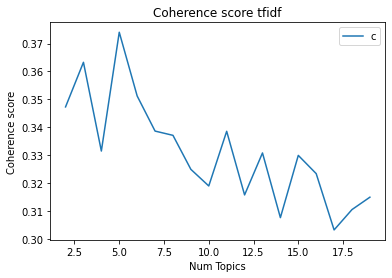

In [35]:
def compute_coherence_values(dictionary, corpus, texts, limit, window_size, start=2, step=1):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        #model = gensim.models.CoherenceModel(model=lda_model_tfidf, texts=data_ready, dictionary=id2word, window_size=60, coherence='c_v')
        #model=gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, window_size=60)
        
        model_list.append(model)
        
        #coherence_model_lda = gensim.models.CoherenceModel(model=lda_model_tfidf, texts=data_ready, dictionary=id2word, window_size=60, coherence='c_v')
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, window_size=window_size)
        
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus_tfidf, texts=data_ready, limit=20, window_size=60, start=2, step=1)

import matplotlib.pyplot as plt
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence score tfidf")
plt.legend(("coherence_values"), loc='best')
plt.show()
#seem

/Users/franziskascharpf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


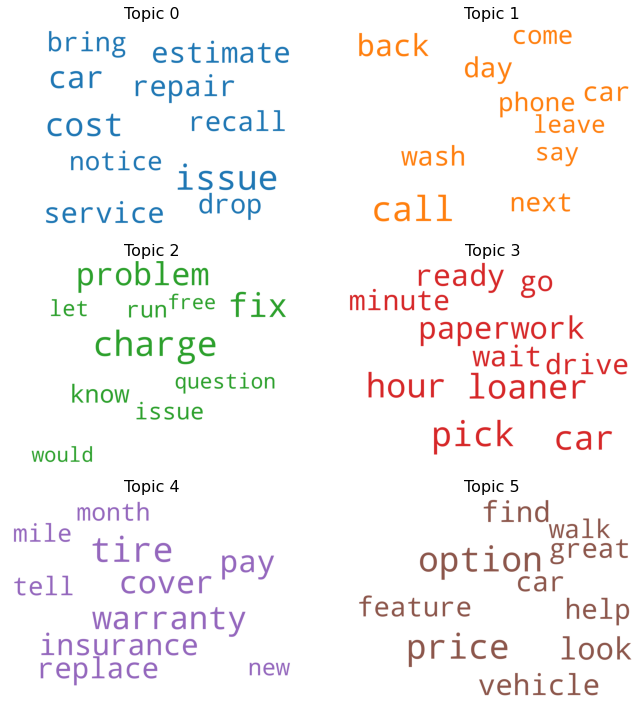

In [52]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_tfidf.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [54]:
all_topics = lda_model_tfidf.get_document_topics(corpus_tfidf, minimum_probability=0)
#all_topics[0]

/Users/franziskascharpf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
def format_topics_sentences(ldamodel=None, corpus=corpus_tfidf, texts=data,ratings=data, documents=data, state=data, city=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
      # Add original text to the end of the output
    contents = pd.Series(texts)
    rating = pd.Series(ratings)
    docs = pd.Series(documents)
    name = pd.Series(state)
    cityname = pd.Series(city)
    sent_topics_df = pd.concat([sent_topics_df, contents, rating, documents,state,cityname], axis=1)
    return(sent_topics_df) 

/Users/franziskascharpf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf, corpus=corpus_tfidf, texts=data_ready, ratings=data['rating'], documents = data['clean_sentence'], state = data['State Name'], city = data['City'])

/Users/franziskascharpf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text','Rating','Docs','Sate Name','City']
#df_dominant_topic.head(10)
df_dominant_topic

/Users/franziskascharpf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Rating,Docs,Sate Name,City
0,0,3.0,0.5655,"pick, car, loaner, hour, paperwork, ready, wai...","[call, micheal, minute, see, reply]",1.0,150 pm sat called back micheal bibbo 14 minut...,Minnesota,Ramsey
1,1,5.0,0.4465,"option, price, look, vehicle, find, car, help,...","[additionally, salesman, tell, car, performanc...",2.0,additionally although the salesman told me th...,NaN,NaN
2,2,4.0,0.5628,"tire, warranty, cover, pay, insurance, replace...","[explain, concern, state, check, coolant, syst...",1.0,after explaining my concern he stated we did ...,NaN,NaN
3,3,5.0,0.4180,"option, price, look, vehicle, find, car, help,...","[pay, half, car, cash, check, bank, finance, m...",3.0,although i paid half the car in cash and had ...,California,Downey
4,4,1.0,0.5810,"call, back, day, wash, car, next, phone, come,...","[come, storm, doorway]",1.0,and he comes storming out of the doorway,Washington,Seattle
...,...,...,...,...,...,...,...,...,...
9983,9983,3.0,0.4854,"pick, car, loaner, hour, paperwork, ready, wai...","[young, even, arrange, car, delivery, hour]",5.0,young mr kleef even arranged car delivery an h...,NaN,NaN
9984,9984,3.0,0.7514,"pick, car, loaner, hour, paperwork, ready, wai...","[help, mobile, food, pantry, time, spend, stud...",5.0,your help with our mobile food pantry the time...,North Carolina,Charlotte
9985,9985,5.0,0.7436,"option, price, look, vehicle, find, car, help,...","[give, detailed, explanation, car, interested,...",5.0,your staff sergio gave me detailed explanation...,Washington,Bellevue
9986,9986,5.0,0.5815,"option, price, look, vehicle, find, car, help,...","[refuse, accept, payment, financing, letter, t...",1.0,your store refused to accept my down payment a...,Texas,Houston


In [74]:
df_dominant_topic.to_excel(r'/Users/franziskascharpf/Desktop/Finalcode/\Overviewtopics_Abholung.xlsx', index = False)

/Users/franziskascharpf/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
